**Content Disclaimer**: This dataset contains real title posts scraped from the r/depression subreddit, and some of the titles contain language that is not safe for work, crude, or offensive. The full dataset is available as `depression.csv`, `preprocessed_thoughts.csv`, `thoughts.csv`, and `token_df.csv`. Unfortunately, I did not provide a sanitized version of my dataset because the words contained were important for the analysis and understanding of the model. Please note that the model, the dataset, and the techniques used are not perfect. If you have any concerns about working with this dataset, looking at my analysis, or the topic in general, you can skip my content overall or click [here](http://iamsorry.com/).

# EDA (Compared to my own self-lemmatized/stemmed words)

The EDA done here is the same process but not with the same data. The data I will be looking at is my own tokenized data.

---
## Imports

In [32]:
import p3_tools as p3t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV # preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # for plotting
from sklearn.naive_bayes import MultinomialNB # Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # transforming

# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [33]:
# import the notebook
thoughts = pd.read_csv('saved_data/token_df.csv')

In [34]:
thoughts.sample(5)

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
18071,18071,1,[removed],hi. realized that I'm having struggle to maint...,23,"['hi', 'realized', 'that', 'I', 'm', 'having',...",124,"['hi', 'realized', 'that', 'i', 'm', 'having',...","['hi', 'realiz', 'that', 'i', 'm', 'have', 'st...","{'with', 'to', 'm', 'that', 'them', 'but', 'my..."
3003,3003,0,[removed],Imagine getting murdered only for some 16 year...,20,"['Imagine', 'getting', 'murdered', 'only', 'fo...",113,"['imagine', 'getting', 'murdered', 'only', 'fo...","['imagin', 'get', 'murder', 'onli', 'for', 'so...","{'some', 'too', 'to', 'only', 'you', 'its', 'f..."
19459,19459,1,"Today at work, I vented to my coworker a bit a...","People notice my depression, but they don’t se...",21,"['People', 'notice', 'my', 'depression', 'but'...",91,"['people', 'notice', 'my', 'depression', 'but'...","['peopl', 'notic', 'my', 'depress', 'but', 'th...","{'don', 'to', 'but', 'is', 'my', 'i', 't', 'do..."
10482,10482,1,My best friend stopped talking to me. My step ...,I don't know what to do anymore. I have no one.,12,"['I', 'don', 't', 'know', 'what', 'to', 'do', ...",47,"['i', 'don', 't', 'know', 'what', 'to', 'do', ...","['i', 'don', 't', 'know', 'what', 'to', 'do', ...","{'don', 'to', 'no', 'have', 't', 'do', 'what',..."
4477,4477,0,"This also goes for The Sopranos, The Hangover,...","If the universe was truly infinite, then somew...",32,"['If', 'the', 'universe', 'was', 'truly', 'inf...",195,"['if', 'the', 'universe', 'wa', 'truly', 'infi...","['if', 'the', 'univers', 'wa', 'truli', 'infin...","{'then', 'out', 'there', 'a', 'as', 'was', 'if..."


In [35]:
depression = thoughts[thoughts['subreddit']==1]
shower = thoughts[thoughts['subreddit']==0]

In [36]:
depression.head()

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
10000,10000,1,About a yr ago I was deep in a deep dark place...,Finally catching my breath.,4,"['Finally', 'catching', 'my', 'breath']",27,"['finally', 'catching', 'my', 'breath']","['final', 'catch', 'my', 'breath']",{'my'}
10001,10001,1,"Hey, i´ve posted a few times here about how my...","""Friends""",1,['Friends'],9,['friend'],['friend'],set()
10002,10002,1,I fail college so I'm the failed one I guess n...,"Yes, im a failure of a child but at least if y...",25,"['Yes', 'im', 'a', 'failure', 'of', 'a', 'chil...",110,"['yes', 'im', 'a', 'failure', 'of', 'a', 'chil...","['ye', 'im', 'a', 'failur', 'of', 'a', 'child'...","{'to', 'at', 'a', 'you', 'but', 'if', 'do', 'i..."
10003,10003,1,#YoungPeople RoundTable’s second part is out! ...,Being Young With BiPolar,4,"['Being', 'Young', 'With', 'BiPolar']",24,"['being', 'young', 'with', 'bipolar']","['be', 'young', 'with', 'bipolar']","{'with', 'being'}"
10004,10004,1,I remember spending quality time with my littl...,Love is the only cure for my depression,8,"['Love', 'is', 'the', 'only', 'cure', 'for', '...",39,"['love', 'is', 'the', 'only', 'cure', 'for', '...","['love', 'is', 'the', 'onli', 'cure', 'for', '...","{'only', 'is', 'the', 'my', 'for'}"


In [37]:
shower.head()

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
0,0,0,[removed],Vampires and skeletons are just different type...,9,"['Vampires', 'and', 'skeletons', 'are', 'just'...",59,"['vampire', 'and', 'skeleton', 'are', 'just', ...","['vampir', 'and', 'skeleton', 'are', 'just', '...","{'are', 'just', 'of', 'and'}"
1,1,0,NaN,Life is actually a telltale game because the c...,13,"['Life', 'is', 'actually', 'a', 'telltale', 'g...",66,"['life', 'is', 'actually', 'a', 'telltale', 'g...","['life', 'is', 'actual', 'a', 'telltal', 'game...","{'to', 'a', 'you', 'is', 'up', 'are', 'the', '..."
2,2,0,[removed],Wouldn’t a botched circumcision just be a peni...,10,"['Wouldn', 't', 'a', 'botched', 'circumcision'...",53,"['wouldn', 't', 'a', 'botched', 'circumcision'...","['wouldn', 't', 'a', 'botch', 'circumcis', 'ju...","{'a', 't', 'just', 'be', 'wouldn'}"
3,3,0,NaN,You might of made a decision that saved your l...,13,"['You', 'might', 'of', 'made', 'a', 'decision'...",70,"['you', 'might', 'of', 'made', 'a', 'decision'...","['you', 'might', 'of', 'made', 'a', 'decis', '...","{'that', 'you', 'a', 'it', 'your', 'of'}"
4,4,0,[removed],"If you have ever opened the toilet water tank,...",24,"['If', 'you', 'have', 'ever', 'opened', 'the',...",116,"['if', 'you', 'have', 'ever', 'opened', 'the',...","['if', 'you', 'have', 'ever', 'open', 'the', '...","{'how', 'for', 'you', 'a', 'have', 'will', 'if..."


# Summary Statistics

---
Nothing has changed much in the descriptive statistics except for the additional columns.

In [38]:
thoughts.describe(include='all')

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
count,20000.000000,20000.000000,16528,20000,20000.000000,20000,20000.000000,20000,20000,20000
unique,NaN,NaN,8587,19557,NaN,19340,NaN,19191,19171,14189
top,NaN,NaN,[removed],Help,NaN,[],NaN,[],[],set()
freq,NaN,NaN,7884,16,NaN,43,NaN,43,43,1372
mean,9999.500000,0.500000,NaN,NaN,12.255650,NaN,64.066200,NaN,NaN,NaN
std,5773.647028,0.500013,NaN,NaN,8.797009,NaN,46.577097,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,4999.750000,0.000000,NaN,NaN,6.000000,NaN,30.000000,NaN,NaN,NaN
50%,9999.500000,0.500000,NaN,NaN,10.000000,NaN,54.000000,NaN,NaN,NaN
75%,14999.250000,1.000000,NaN,NaN,16.000000,NaN,86.000000,NaN,NaN,NaN


In [39]:
depression.describe(include='all')

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
count,10000.00000,10000.0,9979,10000,10000.000000,10000,10000.000000,10000,10000,10000
unique,NaN,NaN,8306,9593,NaN,9433,NaN,9315,9298,5901
top,NaN,NaN,[removed],Help,NaN,[],NaN,[],[],set()
freq,NaN,NaN,1640,16,NaN,35,NaN,35,35,1103
mean,14999.50000,1.0,NaN,NaN,8.556700,NaN,42.687300,NaN,NaN,NaN
std,2886.89568,0.0,NaN,NaN,6.965561,NaN,34.861705,NaN,NaN,NaN
min,10000.00000,1.0,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,12499.75000,1.0,NaN,NaN,4.000000,NaN,21.000000,NaN,NaN,NaN
50%,14999.50000,1.0,NaN,NaN,7.000000,NaN,33.000000,NaN,NaN,NaN
75%,17499.25000,1.0,NaN,NaN,11.000000,NaN,54.000000,NaN,NaN,NaN


In [40]:
shower.describe(include='all')

,Unnamed: 0,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
count,10000.00000,10000.0,6549,10000,10000.000000,10000,10000.000000,10000,10000,10000
unique,NaN,NaN,283,9979,NaN,9922,NaN,9898,9897,8490
top,NaN,NaN,[removed],"If you take literally any one letter out of ""M...",NaN,[],NaN,[],[],set()
freq,NaN,NaN,6244,2,NaN,8,NaN,8,8,269
mean,4999.50000,0.0,NaN,NaN,15.954600,NaN,85.445100,NaN,NaN,NaN
std,2886.89568,0.0,NaN,NaN,8.882355,NaN,47.005578,NaN,NaN,NaN
min,0.00000,0.0,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,2499.75000,0.0,NaN,NaN,10.000000,NaN,53.000000,NaN,NaN,NaN
50%,4999.50000,0.0,NaN,NaN,14.000000,NaN,77.000000,NaN,NaN,NaN
75%,7499.25000,0.0,NaN,NaN,20.000000,NaN,108.000000,NaN,NaN,NaN


# Since I forgot to save csv files properly

---
I will drop the `Unnamed: 0` column.

In [41]:
thoughts.drop(columns='Unnamed: 0',inplace=True)

# Deleted Post Check

---
I will check for any possible deleted, removed, or empty titled posts.

In [42]:
thoughts[thoughts['title']=='[deleted]']

,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords


In [43]:
thoughts[thoughts['title']=='[removed]']

,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
5898,0,[removed],[removed],1,['removed'],9,['removed'],['remov'],set()


In [44]:
thoughts[thoughts['title']=='']

,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords


Since there is only one removed post, I will remove it from the dataframe.

In [45]:
thoughts = thoughts[thoughts['title'] != '[removed]']

In [46]:
thoughts.shape

(19999, 9)

## Let's put the list of lemmatized/stemmed words in their own dataframes

In [47]:
# https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python

thoughts.head()

,subreddit,selftext,title,word_count,tokens,char_count,lem_tokens,pstem_words,stopwords
0,0,[removed],Vampires and skeletons are just different type...,9,"['Vampires', 'and', 'skeletons', 'are', 'just'...",59,"['vampire', 'and', 'skeleton', 'are', 'just', ...","['vampir', 'and', 'skeleton', 'are', 'just', '...","{'are', 'just', 'of', 'and'}"
1,0,NaN,Life is actually a telltale game because the c...,13,"['Life', 'is', 'actually', 'a', 'telltale', 'g...",66,"['life', 'is', 'actually', 'a', 'telltale', 'g...","['life', 'is', 'actual', 'a', 'telltal', 'game...","{'to', 'a', 'you', 'is', 'up', 'are', 'the', '..."
2,0,[removed],Wouldn’t a botched circumcision just be a peni...,10,"['Wouldn', 't', 'a', 'botched', 'circumcision'...",53,"['wouldn', 't', 'a', 'botched', 'circumcision'...","['wouldn', 't', 'a', 'botch', 'circumcis', 'ju...","{'a', 't', 'just', 'be', 'wouldn'}"
3,0,NaN,You might of made a decision that saved your l...,13,"['You', 'might', 'of', 'made', 'a', 'decision'...",70,"['you', 'might', 'of', 'made', 'a', 'decision'...","['you', 'might', 'of', 'made', 'a', 'decis', '...","{'that', 'you', 'a', 'it', 'your', 'of'}"
4,0,[removed],"If you have ever opened the toilet water tank,...",24,"['If', 'you', 'have', 'ever', 'opened', 'the',...",116,"['if', 'you', 'have', 'ever', 'opened', 'the',...","['if', 'you', 'have', 'ever', 'open', 'the', '...","{'how', 'for', 'you', 'a', 'have', 'will', 'if..."


In [48]:
# Instantiate
cvec_stem = CountVectorizer(stop_words='english')
# Fit it 
stem_fit = cvec_stem.fit_transform(thoughts['pstem_words'])
# Store in a DataFrame
stem_df = pd.DataFrame(stem_fit.toarray(), columns=cvec_stem.get_feature_names())

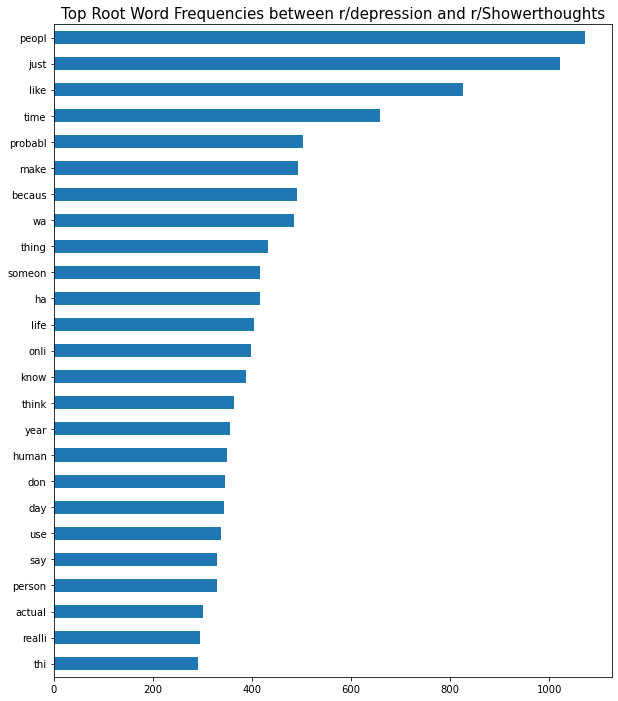

In [57]:
plt.figure(figsize=(10,12))
stem_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0)
plt.title('Top Root Word Frequencies between r/depression and r/Showerthoughts', size=15);

# plt.savefig('imgs/top-words.png');

In [50]:
# Instantiate
cvec_lem = CountVectorizer(stop_words='english')
# Fit it 
lem_fit = cvec_lem.fit_transform(thoughts['lem_tokens'])
# Store in a DataFrame
lem_df = pd.DataFrame(lem_fit.toarray(), columns=cvec_lem.get_feature_names())

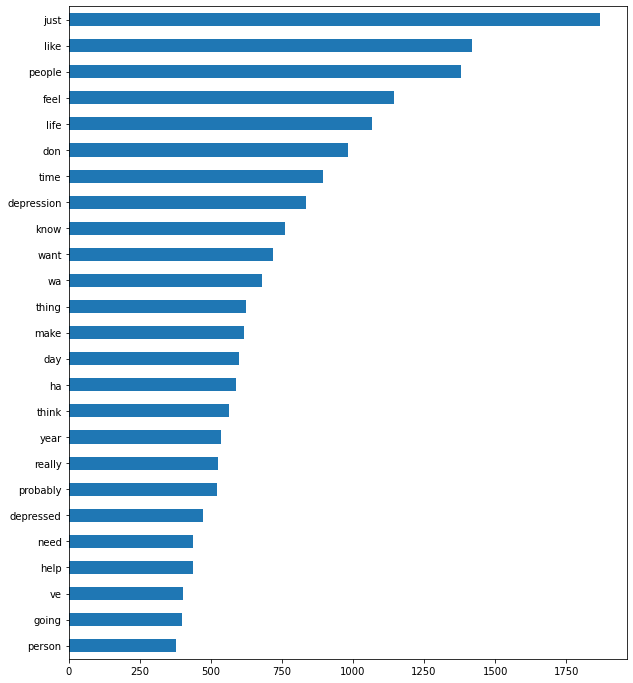

In [51]:
plt.figure(figsize=(10,12))
lem_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0);

The lemmatized tokens did not look as different compared to CountVectorize tokenize the `title` for me. However, when look at the PorterStem tokens, the variants of the word "depress" became the third most word that appears in the dataframe. This might be due to the fact that the dataframe I did this on is the entire `thoughts` dataframe. Now I will show it on "shower thoughts" and "depression" subreddits only.

# Top words from `r/depression` and `r/showerthoughts` using my own lemmatized/stemmed tokens

Depression Words

---
Notice that "depress" moves up to the top spot in my model. This just shows that maybe there could be an improvement in my model if I were to used the stemmed tokens.

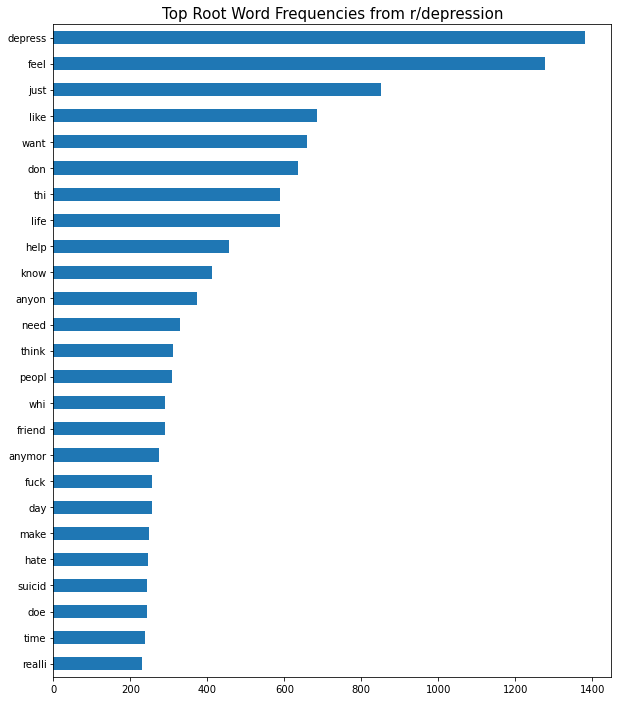

In [59]:
# Instantiate
cvec_stem = CountVectorizer(stop_words='english')
# Fit it 
stem_fit = cvec_stem.fit_transform(depression['pstem_words'])
# Store in a DataFrame
stem_df = pd.DataFrame(stem_fit.toarray(), columns=cvec_stem.get_feature_names())
# Create plot for top 25 words in depression
plt.figure(figsize=(10,12))
stem_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0)

plt.title('Top Root Word Frequencies from r/depression', size=15);

# plt.savefig('imgs/depression-words.png');

Shower Thoughts

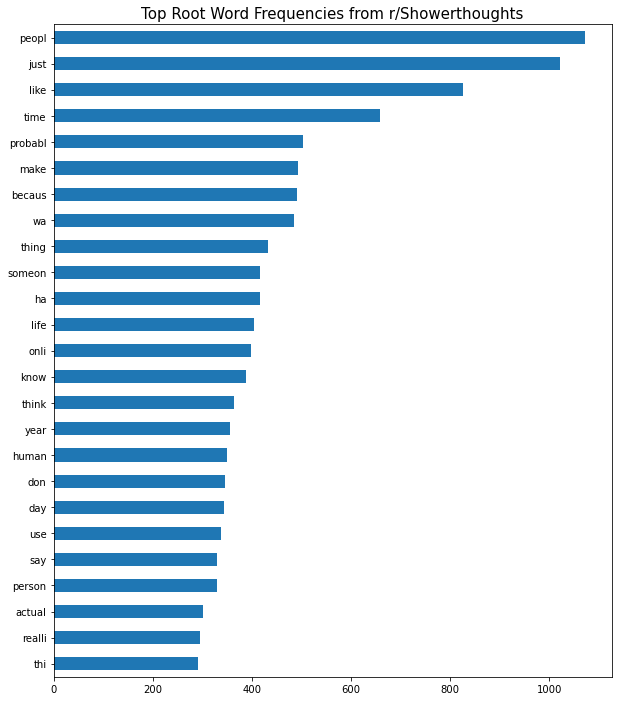

In [60]:
# Instantiate
cvec_stem = CountVectorizer(stop_words='english')
# Fit it 
stem_fit = cvec_stem.fit_transform(shower['pstem_words'])
# Store in a DataFrame
stem_df = pd.DataFrame(stem_fit.toarray(), columns=cvec_stem.get_feature_names())
# Create plot for top 25 words in depression
plt.figure(figsize=(10,12))
stem_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0)

plt.title('Top Root Word Frequencies from r/Showerthoughts', size=15);

# plt.savefig('imgs/shower-words.png');